In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline
#%env CUDA_DEVICE_ORDER='PCI:1:0:0'
#%env CUDA_VISIBLE_DEVICES=0

/usr/lib/python3/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [3]:
df = pd.read_csv('smartphoneatpocket.csv',header=None)

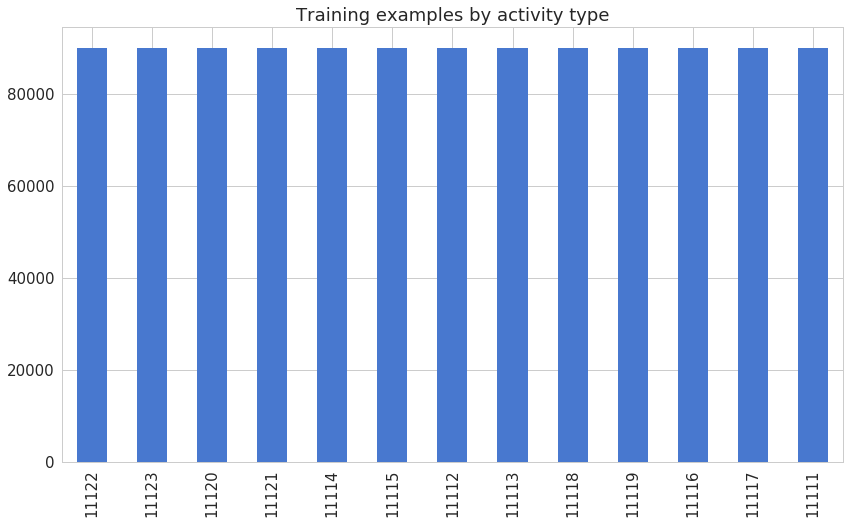

In [4]:
df[13].value_counts().plot(kind='bar', title='Training examples by activity type');

In [5]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-3.132700,-10.188,-1.04880,-3.0399,-0.43163,-0.061478,-2.9783,-0.49480,-0.81215,21.24,42.72,15.42,11111
1,-5.924900,-10.978,1.00790,-5.3538,-1.22180,1.821000,-3.6328,-0.64599,-0.56016,21.12,42.60,15.78,11111
2,-6.960000,-12.136,0.28603,-5.4353,-2.46420,0.840620,-2.9557,-0.34147,-0.60598,20.82,42.60,16.74,11111
3,-3.963500,-15.568,-3.37780,-2.3250,-5.92830,-2.629400,-1.9743,-2.27580,-0.76908,20.64,42.36,17.34,11111
4,-0.054481,-15.677,-4.44020,1.2882,-6.04680,-3.164900,-2.7388,-3.08000,-0.89247,20.40,42.06,18.36,11111


In [6]:
def plot_activity(activity, df):
    data = df[df[13] == activity][df.columns[0:12]][:5000]
    axis = data.plot(subplots=True, figsize=(16, 30), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

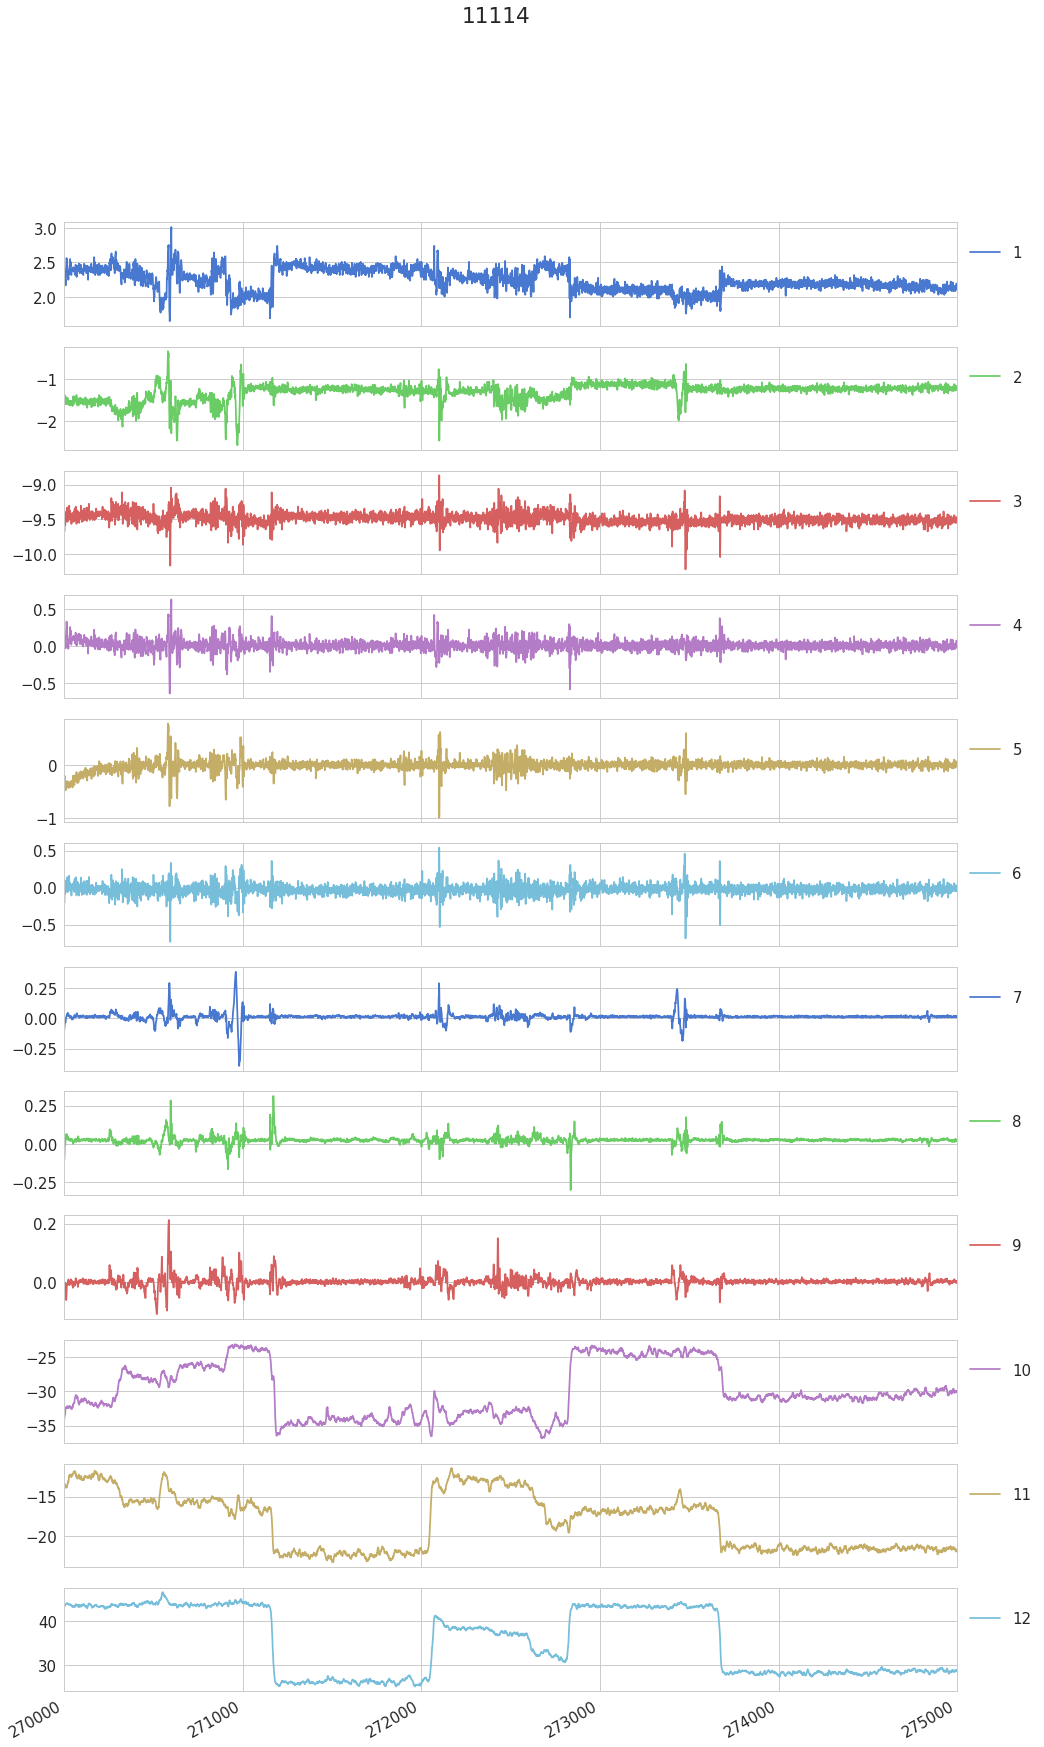

In [7]:
plot_activity(11114, df)

In [8]:
N_TIME_STEPS = 110
N_FEATURES = 12
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    d1 = df[1].values[i: i + N_TIME_STEPS]
    d2 = df[2].values[i: i + N_TIME_STEPS]
    d3 = df[3].values[i: i + N_TIME_STEPS]
    d4 = df[4].values[i: i + N_TIME_STEPS]
    d5 = df[5].values[i: i + N_TIME_STEPS]
    d6 = df[6].values[i: i + N_TIME_STEPS]
    d7 = df[7].values[i: i + N_TIME_STEPS]
    d8 = df[8].values[i: i + N_TIME_STEPS]
    d9 = df[9].values[i: i + N_TIME_STEPS]
    d10 = df[10].values[i: i + N_TIME_STEPS]
    d11 = df[11].values[i: i + N_TIME_STEPS]
    d12 = df[12].values[i: i + N_TIME_STEPS]
    label = stats.mode(df[13][i: i + N_TIME_STEPS])[0][0]
    segments.append([d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12])
    labels.append(label)

In [9]:
len(d1)

110

In [10]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-3.132700,-10.188,-1.04880,-3.0399,-0.43163,-0.061478,-2.9783,-0.49480,-0.81215,21.24,42.72,15.42,11111
1,-5.924900,-10.978,1.00790,-5.3538,-1.22180,1.821000,-3.6328,-0.64599,-0.56016,21.12,42.60,15.78,11111
2,-6.960000,-12.136,0.28603,-5.4353,-2.46420,0.840620,-2.9557,-0.34147,-0.60598,20.82,42.60,16.74,11111
3,-3.963500,-15.568,-3.37780,-2.3250,-5.92830,-2.629400,-1.9743,-2.27580,-0.76908,20.64,42.36,17.34,11111
4,-0.054481,-15.677,-4.44020,1.2882,-6.04680,-3.164900,-2.7388,-3.08000,-0.89247,20.40,42.06,18.36,11111


In [11]:
np.array(segments).shape

(58495, 12, 110)

In [12]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [13]:
reshaped_segments.shape

(58495, 110, 12)

In [14]:
labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [16]:
N_CLASSES = 13
N_HIDDEN_UNITS = 64

def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [17]:


X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [18]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [19]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [20]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [21]:
#tf.reset_default_graph()
#per_process_gpu_memory_fraction=1
#gpu_options = tf.GPUOptions()
#config = tf.ConfigProto(gpu_options=gpu_options)
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
#config.gpu_options.allocator_type = 'BFC'
config.allow_soft_placement = True


N_EPOCHS = 100
BATCH_SIZE = 1024

saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

train_count = len(X_train)




In [22]:
for i in range(1, N_EPOCHS + 1):
    #print(i)
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        #print(start, end)
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})
    
    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print('epoch: ',i, 'test accuracy: ',acc_test, 'loss: ',loss_test)
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print('final results: accuracy: ',acc_final, 'loss: ',loss_final)


epoch:  1 test accuracy:  0.6592016 loss:  2.4286923
epoch:  10 test accuracy:  0.9722198 loss:  1.1017654
epoch:  20 test accuracy:  0.9829045 loss:  0.7220664
epoch:  30 test accuracy:  0.9824771 loss:  0.5276231
epoch:  40 test accuracy:  0.98435766 loss:  0.40447608
epoch:  50 test accuracy:  0.9569194 loss:  0.41777644
epoch:  60 test accuracy:  0.9803402 loss:  0.29092145
epoch:  70 test accuracy:  0.9896572 loss:  0.23563932
epoch:  80 test accuracy:  0.9920506 loss:  0.20133385
epoch:  90 test accuracy:  0.992478 loss:  0.18206573
epoch:  100 test accuracy:  0.9911103 loss:  0.18432687

final results: accuracy:  0.9911103 loss:  0.18432687


In [23]:
tf.reset_default_graph()